## Confirm access to a GPU

In [ ]:
!nvidia-smi

Mon Feb 26 11:40:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Getting data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# start the expriments with 20K of the dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check all of the filenames in the target directory
import os
for dirpath, dirname, filepath in os.walk('/content/pubmed-rct'):
  print(f"There are {len(filepath)} files and {len(dirname)} directories in the file path {dirpath}")

There are 1 files and 5 directories in the file path /content/pubmed-rct
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_20k_RCT
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
There are 3 files and 0 directories in the file path /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
There are 5 files and 6 directories in the file path /content/pubmed-rct/.git
There are 1 files and 1 directories in the file path /content/pubmed-rct/.git/logs
There are 0 files and 2 directories in the file path /content/pubmed-rct/.git/logs/refs
There are 0 files and 1 directories in the file path /content/pubmed-rct/.git/logs/refs/remotes
There are 1 files and 0 directories in the file path /content/pubmed-rct/.git/logs/refs/remotes/origin
There are 1 files and 0 directories in the file path /content/pubmed-rct/.git/logs/refs/heads
There are 0 files and 0 directories in the file path /conten

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
 """
 Read the filename (a text fielname and areturn the lines of text as a list
 Args:
  fielname: a string sontaining the target filepath
 Returns:
  A list of strings with one string per line aform the target filename
  """
 with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(os.path.join(data_dir, "train.txt"))

In [ ]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

How we want our data to look.

how you think the data would be represented
```
[{line_number: 0,
  'target': 'BACKGROUND',
  'text': 'xyz.\n',
  'total_lines': 11}
  ...
  ]'

```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data..

  Takes in filename, reads it contennts and sorts through each line extracting things like
  the target label, the text of the sentence, how many sentences are in the current abstract
  and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "train.txt"))
val_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "dev.txt"))
test_samples = preprocess_text_with_line_numbers(os.path.join(data_dir, "test.txt"))
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 453 ms, sys: 72.9 ms, total: 526 ms
Wall time: 531 ms


(180040, 30212, 30135)

In [ ]:
# Check first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now the data is in the format of a list of dictionaries.
So now we should turn the data into pandas DataFrame and further visualize the data.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(42)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: >

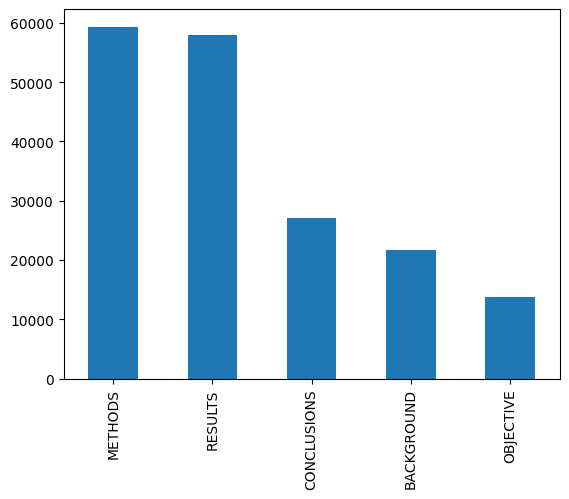

In [ ]:
train_df.target.value_counts().plot(kind = "bar")

<Axes: ylabel='Frequency'>

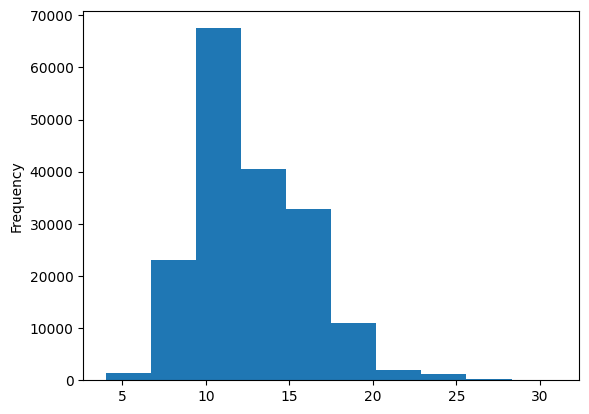

In [ ]:
train_df.total_lines.plot.hist()

### Get list of sentences

In [ ]:
# Convert abstract text line into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [ ]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 liens of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

# Label encoding the labels

In [ ]:
# Extrating lables ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes form LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Making different models

## Model 0: Making a Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evlauate baseline model on validation dtaaset
model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.7218323844829869

In [ ]:
# Making prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

## Download the helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-26 11:40:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-26 11:40:27 (75.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len
min_sent = np.min(sent_lens)
max_sent = np.max(sent_lens)
min_sent, max_sent, avg_sent_len

(1, 296, 26.338269273494777)

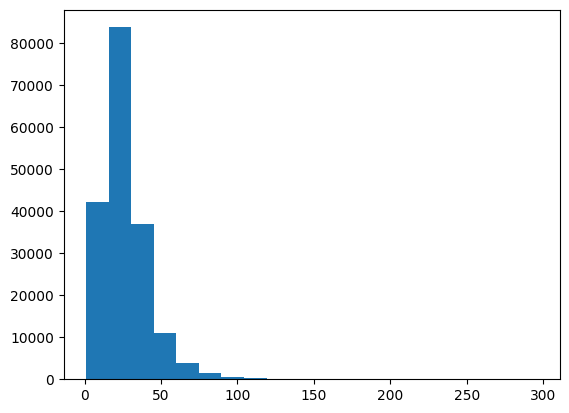

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [ ]:
# How long of a sentence length contains the 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### creating a text vectorizer layer
we want to make a layer which maps our texts from words to number.

In [ ]:
# How many words are in the vocab?
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: patients who tolerated the postrandomization ort were discharged home with another dose of the study drug .

Length of text: 17

Vectorized text: [[  12   67  580    2 6269 9620    9 3994  548    7 1596  131    4    2
    17  300    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
# rct_20k_text_vocab
print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
 text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Crate custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")


In [ ]:
# Show exaple embedding
print(f"Sentence before vecotrization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"sentece after vectorizetion(before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding: \n { embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vecotrization:
 patients who tolerated the postrandomization ort were discharged home with another dose of the study drug .

sentece after vectorizetion(before embedding): 
 [[  12   67  580    2 6269 9620    9 3994  548    7 1596  131    4    2
    17  300    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

sentence after embedding: 
 [[[ 0.01015911 -0.00974683  0.01110756 ... -0.01068343 -0.01933327
    0.03345164]
  [-0.02029279  0.04741347 -0.0321556  ... -0.02086928  0.01621565
   -0.01755942]
  [-0.0371442  -0.03729528 -0.04675278 ... -0.02184376  0.03534203
   -0.01861038]
  ...
  [ 0.04699173  0.03854494 -0.01588617 ... -0.0184399  -0.02607336
    0.01102154]
  [ 0.04699173  0.03854494 -0.01588617 ... -0.0184399  -0.02607336
    0.01102154]
  [ 0.04699173  0.03854494 -0.01588617 ... -0.0184399  -0.02607336
    0.01

## Creating datasets(making sure that our data loads as fast as possible)

We make sure that the our data runs as fast as possible with Tensorflow using the tf.data API

In [ ]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# take the TensorSliceDateset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 =tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

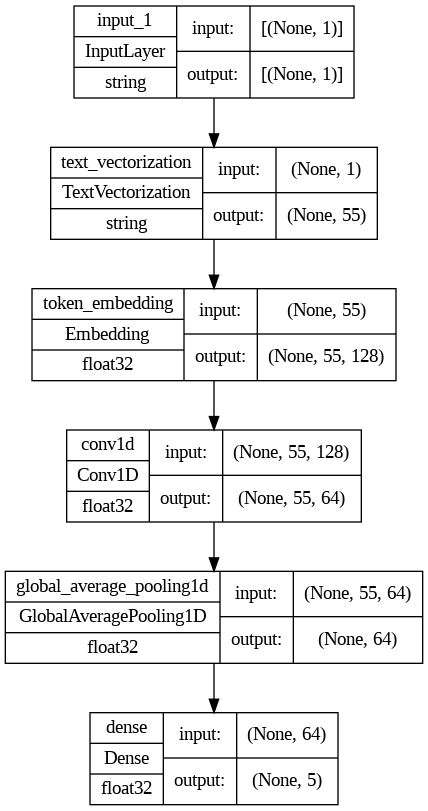

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes = True, show_dtype = True, expand_nested = True)

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * (len(valid_dataset))))

Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9135 - accuracy: 0.6427 - val_loss: 0.6827 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6564 - accuracy: 0.7580 - val_loss: 0.6267 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6161 - accuracy: 0.7745 - val_loss: 0.5935 - val_accuracy: 0.7896


In [ ]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5955 - accuracy: 0.7872


[0.5955444574356079, 0.7872037887573242]

In [ ]:
# make predictions (our model predicts prediction probabilitites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_pred_probs, model_1_pred_probs.shape

(array([[3.9810172e-01, 1.8521111e-01, 9.2074685e-02, 2.8796908e-01,
         3.6643390e-02],
        [4.5449585e-01, 2.5479987e-01, 1.5757525e-02, 2.6570296e-01,
         9.2437798e-03],
        [1.5647979e-01, 5.4631256e-03, 1.7485053e-03, 8.3624333e-01,
         6.5204622e-05],
        ...,
        [3.6679849e-06, 4.9812481e-04, 5.3720060e-04, 2.7219601e-06,
         9.9895823e-01],
        [5.7687730e-02, 4.7948149e-01, 9.6093640e-02, 6.6220015e-02,
         3.0051720e-01],
        [1.5468688e-01, 7.1345764e-01, 5.5979040e-02, 3.2811757e-02,
         4.3064658e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Calculate model_1 resutls
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.72037600953263,
 'precision': 0.783727934459039,
 'recall': 0.7872037600953263,
 'f1': 0.7845315522151772}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name='universal_sentence_encoder')


In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentece after embedding: {use_embedded_sentence[0][:30]}")
print(f"Lenght fo sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 symptoms were decreased in all three groups ( p < @ ) .
Sentece after embedding: [ 0.01957257  0.00239776  0.05519855 -0.03837734  0.03054808  0.05102223
  0.01776562 -0.05917862 -0.06389194  0.03195464  0.08303056 -0.03041272
  0.08261923 -0.03270395  0.02352606 -0.06102567 -0.06713149 -0.03367911
  0.07940982  0.03508539 -0.05601806  0.02495783 -0.04006197  0.01151743
  0.00434283 -0.00150479  0.05760004  0.02564794  0.0682386   0.03750717]
Lenght fo sentence embedding: 512


## Building and fitting an NLP feature extraction model model

In [ ]:
# Define feaure extraction model using kaggle model layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embeddign of each sequence (512)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


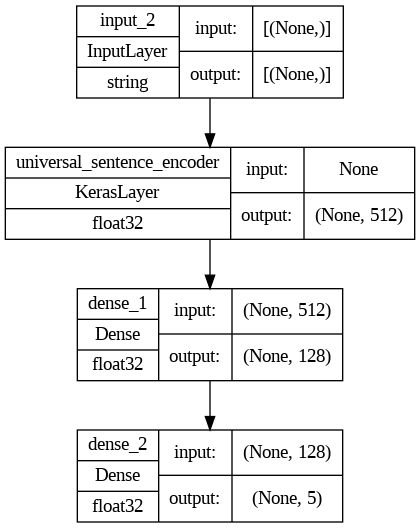

In [ ]:
plot_model(model_2, show_dtype = True, show_shapes = True, expand_nested = True)

In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9169 - accuracy: 0.6508 - val_loss: 0.7940 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7682 - accuracy: 0.7015 - val_loss: 0.7530 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7520 - accuracy: 0.7132 - val_loss: 0.7368 - val_accuracy: 0.7134


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7405 - accuracy: 0.7138


[0.7405322790145874, 0.7137561440467834]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.4123453e-01, 3.5153511e-01, 1.9744381e-03, 1.9732136e-01,
        7.9344464e-03],
       [3.5149753e-01, 5.1051897e-01, 3.6722780e-03, 1.3125072e-01,
        3.0605309e-03],
       [2.3159009e-01, 1.5686952e-01, 2.0306174e-02, 5.5065948e-01,
        4.0574789e-02],
       ...,
       [1.9624182e-03, 5.7782792e-03, 5.6000974e-02, 8.1723894e-04,
        9.3544108e-01],
       [3.9193616e-03, 4.5350537e-02, 1.9858558e-01, 1.4791496e-03,
        7.5066537e-01],
       [1.9515015e-01, 3.2905656e-01, 4.2217356e-01, 7.2642053e-03,
        4.6355508e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)

In [ ]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)

In [ ]:
model_2_results

{'accuracy': 71.37561233946776,
 'precision': 0.7139920265020535,
 'recall': 0.7137561233946776,
 'f1': 0.7106919224660296}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings


### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentneces into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-leverl sequence into characters
split_chars(random_train_sentence)

's y m p t o m s   w e r e   d e c r e a s e d   i n   a l l   t h r e e   g r o u p s   (   p   <   @   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

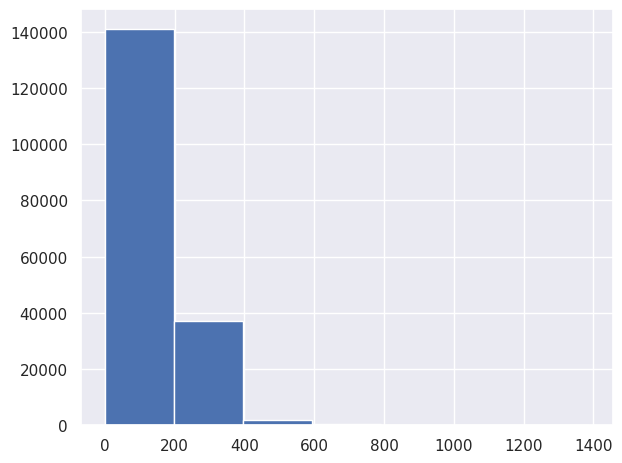

In [ ]:
# Chekc the distribution of our sequences at a character-level
import seaborn as sns

sns.set_theme()
plt.hist(char_lens, bins = 7)
plt.tight_layout()

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
random.choice(train_sentences)

'to detect a standardised effect size of @ at t@ , @ patients from @ general practices are included in each group .'

In [ ]:
# Create char-level tokenvectorizer instance
NUM_CHAR_TOKENS = len(alphabet) +2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize = None,
                                    # standardize = 'lower_and_strip_punctuation',
                                    name = 'char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars: \n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
e f f e c t i v e   i n t e r v e n t i o n s   t o   i m p r o v e   m e d i c a t i o n   a d h e r e n c e   a r e   u s u a l l y   c o m p l e x   a n d   e x p e n s i v e   .
Length of random_train_chars: 80
Vectorized chars: 
[[ 2 17 17  2 11  3  4 21  2  4  6  3  2  8 21  2  6  3  4  7  6  9  3  7
   4 15 14  8  7 21  2 15  2 10  4 11  5  3  4  7  6  5 10 13  2  8  2  6
  11  2  5  8  2 16  9 16  5 12 12 19 11  7 15 14 12  2 24  5  6 10  2 24
  14  2  6  9  4 21  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_embed')

In [ ]:
# Test our character embedding layer
print(f"Charater text: {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding): {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charater text: e f f e c t i v e   i n t e r v e n t i o n s   t o   i m p r o v e   m e d i c a t i o n   a d h e r e n c e   a r e   u s u a l l y   c o m p l e x   a n d   e x p e n s i v e   .
Embedded chars. (after vectorization and embedding): [[[ 0.01268686 -0.04482447 -0.00696484 ...  0.02313666  0.01928635
   -0.04608957]
  [ 0.03530193  0.0427194   0.04014547 ...  0.0154303  -0.04123794
    0.02682422]
  [ 0.03530193  0.0427194   0.04014547 ...  0.0154303  -0.04123794
    0.02682422]
  ...
  [ 0.01775766 -0.04958859 -0.00706669 ...  0.02070764 -0.00687356
   -0.02840697]
  [ 0.01775766 -0.04958859 -0.00706669 ...  0.02070764 -0.00687356
   -0.02840697]
  [ 0.01775766 -0.04958859 -0.00706669 ...  0.02070764 -0.00687356
   -0.02840697]]]
Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

181

### Building a conv1D mdoel ot fit on a character embedding

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1, ), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'Model_3_conv_1D_character_embeddings')
# Compile
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Summary
model_3.summary()

Model: "Model_3_conv_1D_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (

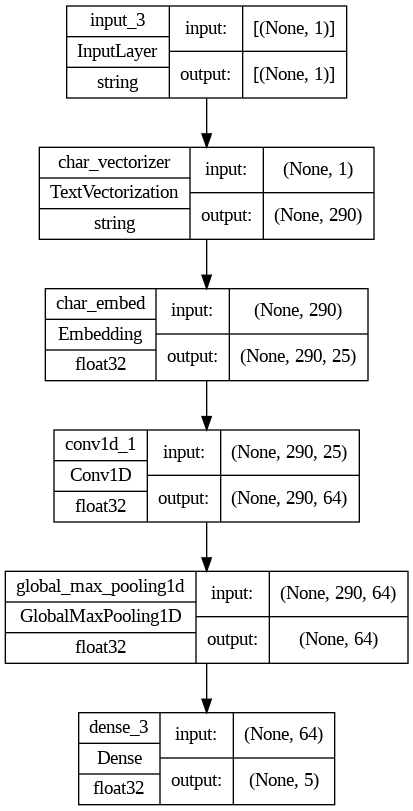

In [ ]:
plot_model(model_3, show_shapes = True, show_dtype = True, show_layer_names = True, expand_nested = True)

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * (len(train_char_dataset))),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * (len(val_char_dataset))))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2711 - accuracy: 0.4832 - val_loss: 1.0496 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0087 - accuracy: 0.5994 - val_loss: 0.9524 - val_accuracy: 0.6267
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9282 - accuracy: 0.6358 - val_loss: 0.8723 - val_accuracy: 0.6725


In [ ]:
# Make prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.14280969, 0.64096326, 0.0456307 , 0.12196998, 0.04862637],
       [0.38151473, 0.30569166, 0.03591552, 0.23040305, 0.04647506],
       [0.22219631, 0.23719233, 0.25698107, 0.18155651, 0.10207374],
       ...,
       [0.02231498, 0.06745879, 0.08470178, 0.04211676, 0.78340775],
       [0.02301618, 0.10474994, 0.18105611, 0.04962552, 0.6415522 ],
       [0.28535292, 0.48272678, 0.10166324, 0.10510342, 0.02515355]],
      dtype=float32)

In [ ]:
# Convert the pred probs into the class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)

In [ ]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 2, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.80166821130676,
 'precision': 0.653980049579184,
 'recall': 0.6580166821130676,
 'f1': 0.6475143211382222}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 78.72037600953263,
 'precision': 0.783727934459039,
 'recall': 0.7872037600953263,
 'f1': 0.7845315522151772}

## Model 4: Combining pretrained token embeddings + characters

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

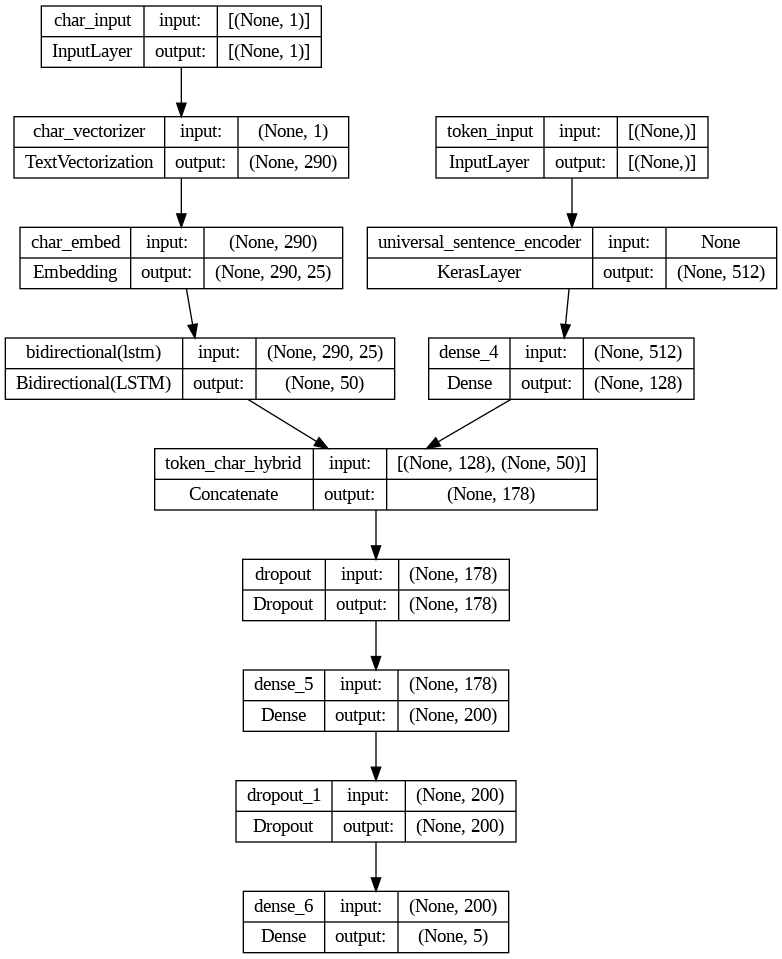

In [ ]:
# Plot hybrid token and character model
plot_model(model_4, show_shapes = True)

In [ ]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Combining token and character data into a tf.data Dataset

In [ ]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_labels) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check out our trianing char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a mdoel on tokens and character-level sequuences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(train_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 65ms/step - loss: 0.9615 - accuracy: 0.6207 - val_loss: 0.7746 - val_accuracy: 0.6992
Epoch 2/3
562/562 [==============================] - 34s 60ms/step - loss: 0.7842 - accuracy: 0.6977 - val_loss: 0.7099 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 30s 54ms/step - loss: 0.7639 - accuracy: 0.7106 - val_loss: 0.6848 - val_accuracy: 0.7407


In [ ]:
model_1_results

{'accuracy': 78.72037600953263,
 'precision': 0.783727934459039,
 'recall': 0.7872037600953263,
 'f1': 0.7845315522151772}

In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6897 - accuracy: 0.7383


[0.6897046566009521, 0.7383158802986145]

In [ ]:
# Make predictions using the token_character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 21s 19ms/step


In [ ]:
model_4_pred_probs

array([[4.6511534e-01, 2.5487155e-01, 3.6582323e-03, 2.6952249e-01,
        6.8324050e-03],
       [4.0541178e-01, 3.6189976e-01, 4.9011200e-03, 2.2556682e-01,
        2.2204989e-03],
       [2.7545175e-01, 1.0553804e-01, 5.3169634e-02, 5.2194399e-01,
        4.3896463e-02],
       ...,
       [6.5514026e-04, 1.0994395e-02, 6.2918276e-02, 2.4852072e-04,
        9.2518365e-01],
       [8.8586649e-03, 6.4970322e-02, 2.0897990e-01, 4.8116460e-03,
        7.1237946e-01],
       [4.3675449e-01, 3.2073444e-01, 1.7855152e-01, 2.9849781e-02,
        3.4109764e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 0])>

In [ ]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.83159009665033,
 'precision': 0.7373370895509124,
 'recall': 0.7383159009665033,
 'f1': 0.7367822098596906}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


## Create positional embeddings

In [ ]:
# how many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

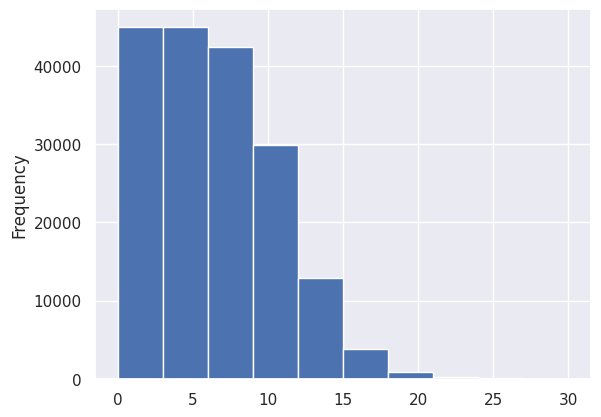

In [ ]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot_encoded tensors of our 'line_number' column
train_line_numbers_one_hot =tf.one_hot(train_df['line_number'].to_numpy(),depth = 15)
val_line_numbers_one_hot =tf.one_hot(val_df['line_number'].to_numpy(),depth = 15)
test_line_numbers_one_hot =tf.one_hot(test_df['line_number'].to_numpy(),depth = 15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Doing the same for the total lines feature

In [ ]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

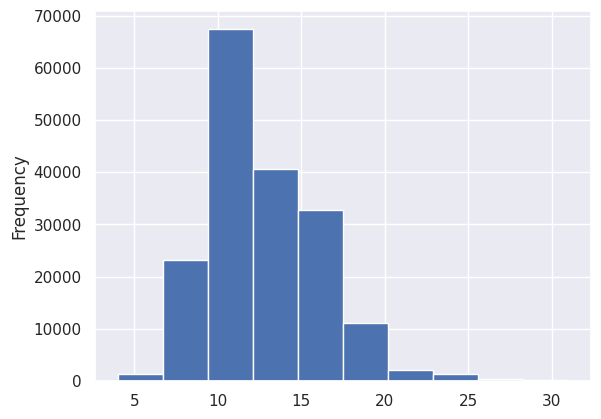

In [ ]:
# Check the distributions of total_lines
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 97)

20.0

In [ ]:
# use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. create a model for the 'line_number' feature
4. Create a model for the 'total_lines'feature
5. Combine the outputs of 1 &2 using tf.keras.layers.Concatenate
6. Combine the outputs of the 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embeddign and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and the outputs of 7 into a tf.keras.Model

In [ ]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# Creating a dorpout layer
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

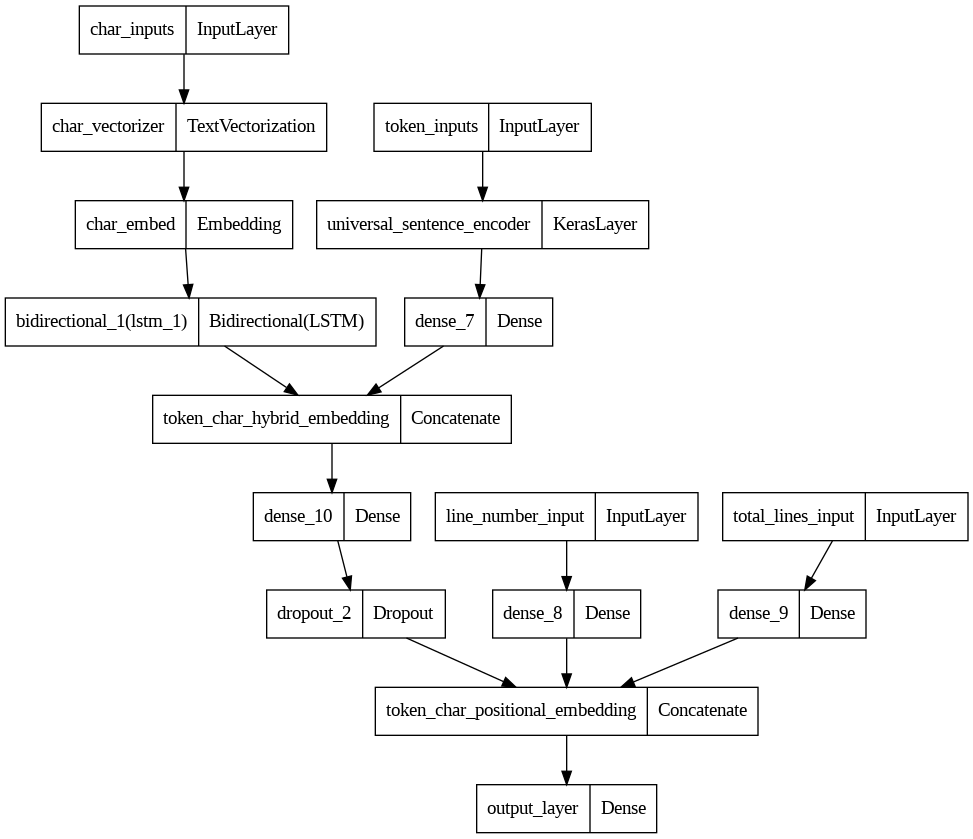

In [ ]:
plot_model(model_5)

What is label smoothing?

for eg: if our model gets too confident on a single class (e.g. it's prediction probability is really high), it may get stuck on that class and not consider other classes.

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [ ]:
# Compile token, char, adn positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),# helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


### Create tribrid embedding datasets uding tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validataion daset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting evaluating and making prediciton with our tribrid model

In [ ]:
model_5.fit(train_char_token_pos_dataset,
            steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
            epochs = 3,
            validation_data = val_char_token_pos_dataset,
            validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 67s 90ms/step - loss: 1.1042 - accuracy: 0.7190 - val_loss: 0.9892 - val_accuracy: 0.8009
Epoch 2/3
562/562 [==============================] - 43s 77ms/step - loss: 0.9673 - accuracy: 0.8147 - val_loss: 0.9507 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 42s 74ms/step - loss: 0.9494 - accuracy: 0.8230 - val_loss: 0.9381 - val_accuracy: 0.8328


In [ ]:
# Make predictions with the char toekn pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 37s 34ms/step


array([[0.48600987, 0.11192215, 0.0115268 , 0.3755816 , 0.0149595 ],
       [0.51613754, 0.07469203, 0.03760164, 0.36197057, 0.00959824],
       [0.29591987, 0.0926899 , 0.10912685, 0.44747978, 0.05478364],
       ...,
       [0.03933686, 0.10710313, 0.04162693, 0.02989955, 0.78203356],
       [0.02843228, 0.3112213 , 0.07565016, 0.02591728, 0.558779  ],
       [0.1776024 , 0.6034215 , 0.11311281, 0.04632688, 0.05953643]],
      dtype=float32)

In [ ]:
# Converting the pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.44697471203494,
 'precision': 0.8334493207896863,
 'recall': 0.8344697471203495,
 'f1': 0.8335218947082755}

In [ ]:
model_4_results

{'accuracy': 73.83159009665033,
 'precision': 0.7373370895509124,
 'recall': 0.7383159009665033,
 'f1': 0.7367822098596906}

# Compare model resutls


In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})

all_model_results = all_model_results.transpose()

In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.720376,0.783728,0.787204,0.784532
model_2_pretrained_token_embedding,71.375612,0.713992,0.713756,0.710692
model_3_custom_char_embedding,65.801668,0.653980,0.658017,0.647514
model_4_hybrid_char_token_embedding,73.831590,0.737337,0.738316,0.736782
model_5_pos_char_token_embedding,83.446975,0.833449,0.834470,0.833522


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

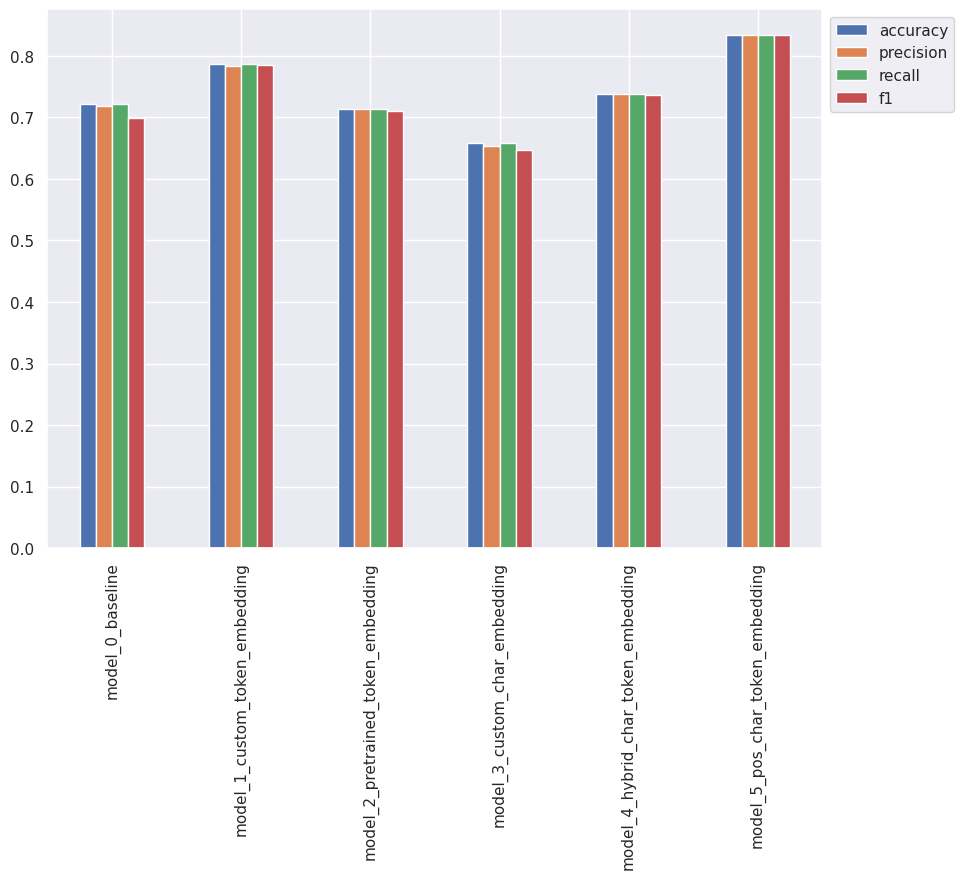

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0))

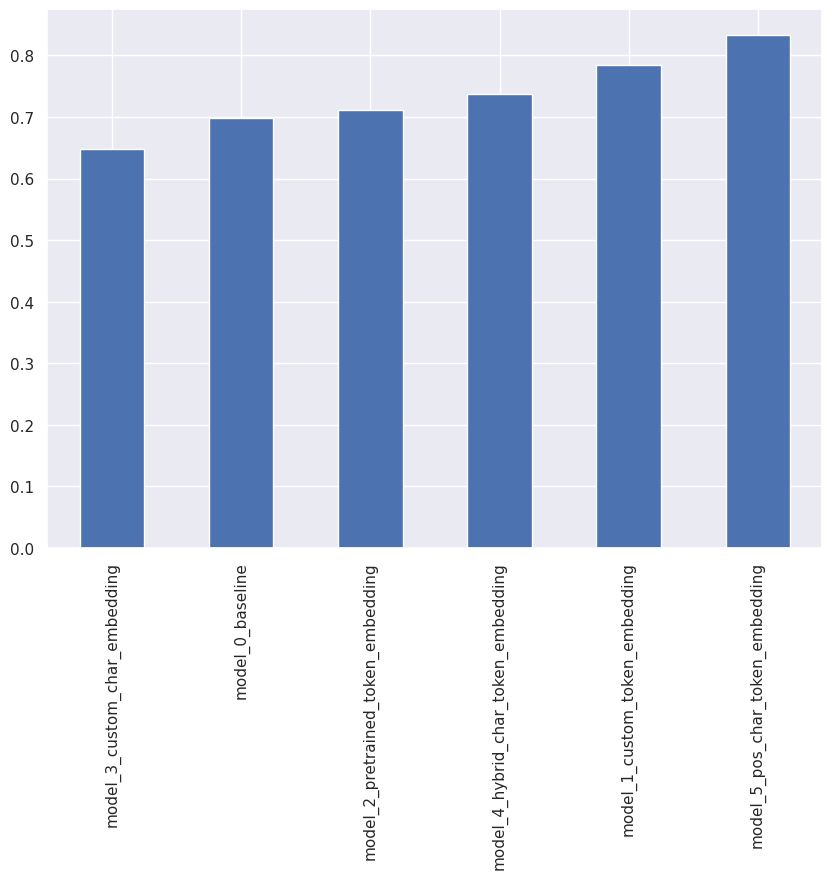

In [ ]:
#Sort mdoels results by f1-score
all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10, 7));

# Save and load model

In [ ]:
model_5.save('skimlit_tribrid_model')

In [ ]:
# Load in mdoel_5
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
loaded_pred_probs =loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds[:10]

945/945 [==============================] - 23s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the result of our loaded mdoel
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

{'accuracy': 83.44697471203494,
 'precision': 0.8334493207896863,
 'recall': 0.8344697471203495,
 'f1': 0.8335218947082755}

In [ ]:
model_5_results

{'accuracy': 83.44697471203494,
 'precision': 0.8334493207896863,
 'recall': 0.8344697471203495,
 'f1': 0.8335218947082755}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  